In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# Paths
train_dir = "Skin cancer ISIC The International Skin Imaging Collaboration/Train"  # Update with the actual path
test_dir = "Skin cancer ISIC The International Skin Imaging Collaboration/Test"    # Update with the actual path

# Image Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data Augmentation and Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Load Pre-trained Model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Freeze Base Model Layers
for layer in base_model.layers:
    layer.trainable = False

# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10
)

# Unfreeze Base Model and Fine-Tune
for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10
)

# Save the Model
model.save("skin_cancer_detector.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


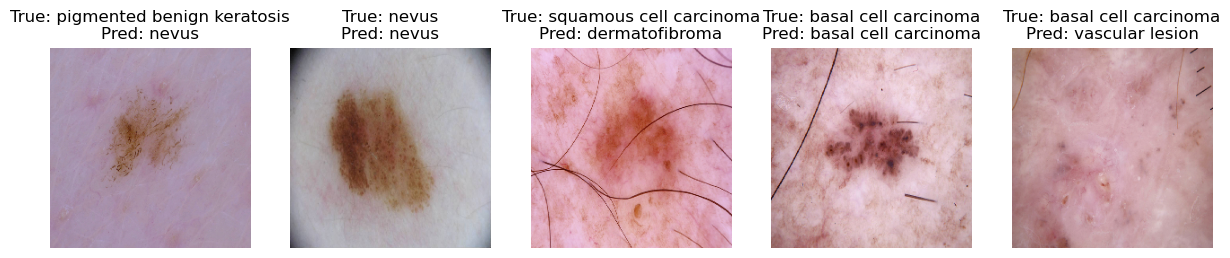

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Function to visualize predictions
def visualize_test_predictions(generator, model, num_samples=5):
    """
    Visualize predictions on random test images.
    
    Args:
        generator: The test data generator.
        model: The trained model.
        num_samples: Number of random samples to visualize.
    """
    # Randomly select images from the test dataset
    indices = random.sample(range(len(generator.filepaths)), num_samples)
    images = []
    true_labels = []
    predicted_labels = []

    for idx in indices:
        # Load the image
        img_path = generator.filepaths[idx]
        img = tf.keras.utils.load_img(img_path, target_size=IMG_SIZE)
        img_array = tf.keras.utils.img_to_array(img) / 255.0

        # Predict using the model
        prediction = model.predict(np.expand_dims(img_array, axis=0))
        predicted_class = np.argmax(prediction[0])

        # Store results
        images.append(img)
        true_labels.append(list(generator.class_indices.keys())[generator.labels[idx]])
        predicted_labels.append(list(generator.class_indices.keys())[predicted_class])

    # Plot the results
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}")
        plt.axis("off")
    plt.show()

# Visualize predictions on test dataset
visualize_test_predictions(test_generator, model, num_samples=5)
